### Librerie:

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, RocCurveDisplay
from imblearn.over_sampling import SMOTE


### Caricamento file 'df_EDA' derivante da FASE EDA e VISUALIZZAZIONE:

In [64]:
df_logRegr = pd.read_csv('data/df_EDA')
df_logRegr

,person_age,person_education,person_income,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22,3,71948.0,RENT,35000.0,PERSONAL,16.02,0.49,3,561,0,1
1,21,0,12282.0,OWN,1000.0,EDUCATION,11.14,0.08,2,504,1,0
2,25,0,12438.0,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3,635,0,1
3,23,2,79753.0,RENT,35000.0,MEDICAL,15.23,0.44,2,675,0,1
4,24,3,66135.0,RENT,35000.0,MEDICAL,14.27,0.53,4,586,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
38539,27,1,47971.0,RENT,15000.0,MEDICAL,15.66,0.31,3,645,0,1
38540,37,1,65800.0,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11,621,0,1
38541,33,1,56942.0,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10,668,0,1
38542,29,2,33164.0,RENT,12000.0,EDUCATION,13.23,0.36,6,604,0,1


### Encoding:

##### One-Hot Encoding su Variabili 'person_home_ownershio' e 'loan_amnt' e VISUALIZZAZIONE Encoding:

In [65]:
df_logRegr = pd.get_dummies(df_logRegr, columns=['person_home_ownership', 'loan_intent'], prefix=['home', 'intent'], drop_first=True)
for column in df_logRegr:
    if df_logRegr[column].dtype == bool:
        df_logRegr[column] = df_logRegr[column].astype(int)

df_logRegr

,person_age,person_education,person_income,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,home_OWN,home_RENT,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE
0,22,3,71948.0,35000.0,16.02,0.49,3,561,0,1,0,1,0,0,0,1,0
1,21,0,12282.0,1000.0,11.14,0.08,2,504,1,0,1,0,1,0,0,0,0
2,25,0,12438.0,5500.0,12.87,0.44,3,635,0,1,0,0,0,0,1,0,0
3,23,2,79753.0,35000.0,15.23,0.44,2,675,0,1,0,1,0,0,1,0,0
4,24,3,66135.0,35000.0,14.27,0.53,4,586,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38539,27,1,47971.0,15000.0,15.66,0.31,3,645,0,1,0,1,0,0,1,0,0
38540,37,1,65800.0,9000.0,14.07,0.14,11,621,0,1,0,1,0,1,0,0,0
38541,33,1,56942.0,2771.0,10.02,0.05,10,668,0,1,0,1,0,0,0,0,0
38542,29,2,33164.0,12000.0,13.23,0.36,6,604,0,1,0,1,1,0,0,0,0


### Standardizzazione Variabile 'loan_status' con uso di Pipeline:

In [66]:
# X è tutto il resto, escludendo la variabile target
X = df_logRegr.drop(columns=['loan_status'])
# y è la variabile target: loan_status
Y = df_logRegr['loan_status']



In [67]:
pipe = Pipeline([
    ('scaler', StandardScaler()), # Scaler SOLO su X
    ('logreg', LogisticRegression(class_weight='balanced')) 
])
pipe.fit(X, Y) # Y non Standardizzato

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(class_weight='balanced'))])

### Calcolo VIF (collinearità):

In [68]:
X_vif = pd.DataFrame(X, columns=pipe.named_steps['scaler'].get_feature_names_out(X.columns))

# Calcoliamo VIF per ogni colonna
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

display(vif_data.sort_values(by="VIF", ascending=False))

,feature,VIF
0,person_age,89.453494
7,credit_score,75.803898
2,person_income,27.105168
5,loan_percent_income,24.213065
3,loan_amnt,23.893087
4,loan_int_rate,14.718364
6,cb_person_cred_hist_length,12.587825
10,home_RENT,2.892675
1,person_education,2.752797
11,intent_EDUCATION,2.292536


##### Visualizzazione Distribuzione VIF (>10) per ogni variabile:

In [69]:
# Visualizziamo le feature con VIF > 10
high_vif = vif_data[vif_data["VIF"] > 10]
if not high_vif.empty:
    print("Feature con VIF > 10:")
    print(high_vif)

Feature con VIF > 10:
                      feature        VIF
0                  person_age  89.453494
2               person_income  27.105168
3                   loan_amnt  23.893087
4               loan_int_rate  14.718364
5         loan_percent_income  24.213065
6  cb_person_cred_hist_length  12.587825
7                credit_score  75.803898


##### Eliminazione feature con alto VIF:

In [70]:
# Eliminazione delle feature 'person_age' e 'loan_percent_income'
X = X.drop(columns=['person_age', 'loan_percent_income'])

##### Check Distribuzione VIF post RIMOZIONE feature con VIF alto (>10):

In [71]:
# 1. Crea un nuovo scaler (non usare quello vecchio nella pipeline)
scaler = StandardScaler()

# 2. Applica lo scaler a X (che ora ha meno colonne)
X_scaled = scaler.fit_transform(X)

# 3. Crea un DataFrame con i dati scalati e i nomi delle colonne
X_vif = pd.DataFrame(X_scaled, columns=X.columns)

# 4. Calcola il VIF per ogni colonna
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# 5. Mostra le feature con VIF alto
high_vif = vif_data[vif_data["VIF"] > 10]
if not high_vif.empty:
    print("⚠️ Feature con VIF > 10:")
    print(high_vif)
else:
    print("✅ Nessuna feature con VIF > 10")

# 6. Mostra tutti i VIF
display(vif_data.sort_values(by="VIF", ascending=False))


✅ Nessuna feature con VIF > 10


,feature,VIF
9,intent_EDUCATION,1.844327
11,intent_MEDICAL,1.814458
13,intent_VENTURE,1.761519
12,intent_PERSONAL,1.721657
10,intent_HOMEIMPROVEMENT,1.487117
1,person_income,1.326556
8,home_RENT,1.261394
2,loan_amnt,1.202722
7,home_OWN,1.171760
6,previous_loan_defaults_on_file,1.127143


### Train/Test Split (70%-30%) prima di Predizione:

In [72]:
# Divisione 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

In [73]:
# Nuova X e Y per Bilanciamento con SMOTE prima di bilanciare con class_weight='balanced':
smote = SMOTE(random_state=42)
X_train_Smote, y_train_Smote = smote.fit_resample(X_train,y_train)

### Predizione:

##### Creazione Modello LogisticRegression (Pipeline):

In [74]:
# Creazione della pipeline
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),             # Step 1: standardizzazione
    ('logreg', LogisticRegression(            # Step 2: modello
        solver='liblinear',                   # Ottimo per dataset non enormi
        penalty='l2',                         # Regularizzazione di default (Ridge)
        C=1.0,                                 # Inverso della forza di regolarizzazione
        class_weight='balanced',              # Gestione classi sbilanciate
        random_state=42
    ))
])

##### Fit sui Dati di Addestramento:

In [75]:
# Fit della pipeline sui dati di addestramento
logreg_pipeline.fit(X_train_Smote, y_train_Smote)


Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

##### Inizio Previsione dopo essersi allenato:

In [76]:
# Previsione del modello 
y_test_pred = logreg_pipeline.predict(X_test)

### Valutazioni Predizione:

##### Accuracy:

In [77]:
# Calcolo dell'accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy del modello: {accuracy:.2f}")

Accuracy del modello: 0.87


##### ConfusionMatrix: 

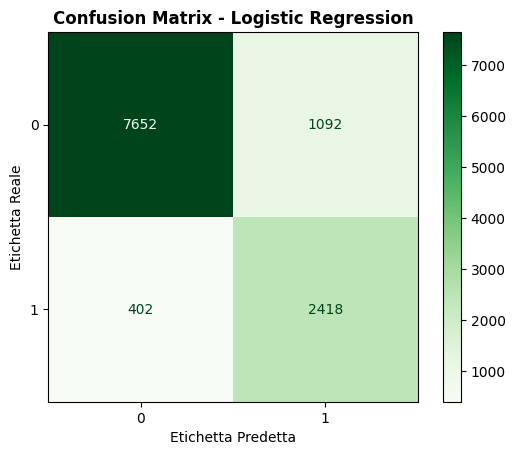

In [78]:
# Matrice di Confusione
cm = confusion_matrix(y_test, y_test_pred)

# Visualizzazione della matrice
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_pipeline.classes_)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix - Logistic Regression", weight ='bold') 
plt.xlabel("Etichetta Predetta")
plt.ylabel("Etichetta Reale")
plt.show()


##### Calcolo Report completo:

In [79]:
# Calcolo report completo
report = classification_report(y_test, y_test_pred, target_names=["Negato (0)", "Concesso (1)"])
print(report)

              precision    recall  f1-score   support

  Negato (0)       0.95      0.88      0.91      8744
Concesso (1)       0.69      0.86      0.76      2820

    accuracy                           0.87     11564
   macro avg       0.82      0.87      0.84     11564
weighted avg       0.89      0.87      0.88     11564



Classe 1 (“Concesso”) ha alto recall = il modello becca quasi tutti i clienti buoni (2627 su 2820).

	•	Classe 0 (“Negato”) ha precision più alta = il modello è molto sicuro nel negare (pochissimi falsi positivi).
	
	•	F1-score Classe 1 = 0.76 = equilibrio accettabile.

##### Probabilità (ROC Curve):

C:\Users\Francesca\AppData\Local\Temp\ipykernel_14820\2305791527.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier", color='green')


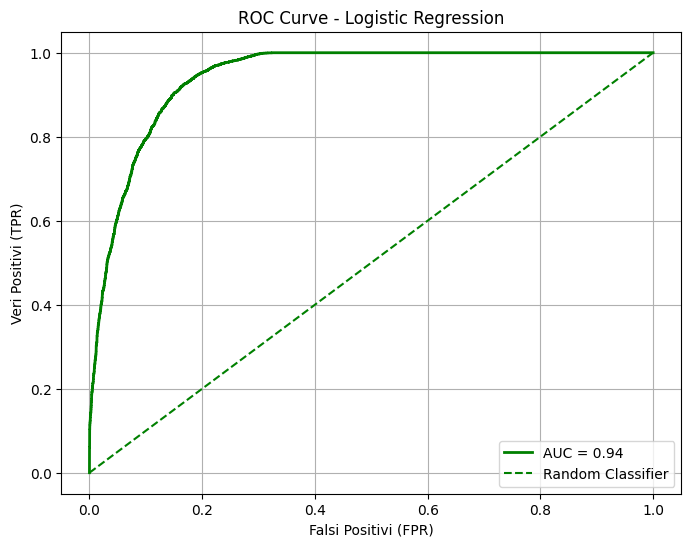

In [88]:
# Probabilità predette (non etichette)
y_probs = logreg_pipeline.predict_proba(X_test)[:, 1]  # solo colonna 1 = classe 'concesso'

# Calcolo ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Visualizzazione della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='green', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier", color='green')
plt.xlabel("Falsi Positivi (FPR)")
plt.ylabel("Veri Positivi (TPR)")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##### Interpretazione visiva:
	•	Curva verde: sale subito verso l’alto, segno che il modello riesce a catturare correttamente i positivi (prestiti concessi = 1) 
	    con bassa percentuale di falsi positivi.
	•	Linea tratteggiata (Random Classifier): rappresenta il modello che indovina a caso. Tutto ciò che sta sopra questa linea è buono,
	    più ci allontani, meglio è.

##### AUC = 0.95:
	•	Questo è un risultato eccellente.
	•	Significa che il 95% delle volte il modello distingue correttamente tra chi riceverà il prestito e chi no.
	•	In pratica: ottimo equilibrio tra sensibilità (recall) e specificità.

Cosa puoi dire nelle slide o a voce:

“Il nostro modello di regressione logistica ha ottenuto un’area sotto la curva ROC pari a 0.95, indicando un’elevata capacità discriminativa. 
Questo lo rende un modello affidabile nella distinzione tra prestiti approvati e rifiutati.”

### Inferenza:

##### Prima Inferenza senza scartare nessuna variabile:

In [81]:
# Separazione X e y
X_inf = df_logRegr.drop(columns=['loan_status'])
y_inf = df_logRegr['loan_status']

X_pred = df_logRegr.drop(columns=['loan_status'])
y_pred = df_logRegr['loan_status']

# Divisione in Train e Test
X_train_inf, X_test_inf, y_train_inf, y_test_inf = train_test_split(
    X_inf, y_inf, test_size=0.3, random_state=42)

X_train_pred, X_test_pred, y_train_pred, y_test_pred = train_test_split(
    X_pred, y_pred, test_size=0.3, random_state=42)

In [82]:
# Aggiungiamo l'intercetta
X_train_inf_const = sm.add_constant(X_train_inf)

# Modello logit per inferenza
logit_model = sm.Logit(y_train_inf, X_train_inf_const)
result = logit_model.fit(maxiter=500)

# Risultati statistici
print(result.summary())

         Current function value: 0.234076
         Iterations: 500
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                26980
Model:                          Logit   Df Residuals:                    26963
Method:                           MLE   Df Model:                           16
Date:                Sun, 01 Jun 2025   Pseudo R-squ.:                  0.5804
Time:                        21:06:23   Log-Likelihood:                -6315.4
converged:                      False   LL-Null:                       -15052.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.7567      0.380      1.992      0.046       0.012       1.501
pers

c:\Users\Francesca\Desktop\TEAM_PROJECT\project\CUSTOMER_SCORING1.0\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### Notiamo che 'previous_loan_defaults_on_file' risulta avere:
##### Un valore P molto ELEVATO 
##### Un ErroreStandard molto ELVATO

##### Seconda Inferenza scartando 'previous_loan_defualts_on_file':

In [83]:
X_inf_2 = X_inf.drop(columns=['previous_loan_defaults_on_file'])
y_inf = df_logRegr['loan_status']

X_pred = X_inf.drop(columns=['previous_loan_defaults_on_file'])
y_pred = df_logRegr['loan_status']

# Divisione in Train e Test
X_train_inf, X_test_inf, y_train_inf, y_test_inf = train_test_split(
    X_inf_2, y_inf, test_size=0.3, random_state=42)

X_train_pred, X_test_pred, y_train_pred, y_test_pred = train_test_split(
    X_pred, y_pred, test_size=0.3, random_state=42)

In [84]:
# Aggiungiamo l'intercetta
X_train_inf_const = sm.add_constant(X_train_inf)

# Modello logit per inferenza
logit_model = sm.Logit(y_train_inf, X_train_inf_const)
result = logit_model.fit(maxiter=100)

# Risultati statistici
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.384390
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                26980
Model:                          Logit   Df Residuals:                    26964
Method:                           MLE   Df Model:                           15
Date:                Sun, 01 Jun 2025   Pseudo R-squ.:                  0.3110
Time:                        21:06:23   Log-Likelihood:                -10371.
converged:                       True   LL-Null:                       -15052.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -6.1480      0.287    -21.410      0.000      

##### Terza Inferenza scartando:
##### 'credit_score','intent_HOMEIMPROVEMENT',
##### 'previous_loan_defaults_on_file','person_education','person_age':

In [85]:
# Facciamo TERZA inferenza, levando anche 'credit_score' e 'intent_HOMEIMPROVEMENT' perchè hanno p value ALTO:
X_inf_3 = X_inf.drop(columns=['credit_score','intent_HOMEIMPROVEMENT','previous_loan_defaults_on_file','person_education','person_age'])
y_inf = df_logRegr['loan_status']

X_pred = X_inf.drop(columns=['credit_score','intent_HOMEIMPROVEMENT','previous_loan_defaults_on_file'])
y_pred = df_logRegr['loan_status']

# Divisione in Train e Test
X_train_inf, X_test_inf, y_train_inf, y_test_inf = train_test_split(
    X_inf_3, y_inf, test_size=0.3, random_state=42)

X_train_pred, X_test_pred, y_train_pred, y_test_pred = train_test_split(
    X_pred, y_pred, test_size=0.3, random_state=42)


In [86]:
# Aggiungiamo l'intercetta
X_train_inf_const = sm.add_constant(X_train_inf)

# Modello logit per inferenza
logit_model = sm.Logit(y_train_inf, X_train_inf_const)
result = logit_model.fit(maxiter=100)

# Risultati statistici 
print(result.summary())



Optimization terminated successfully.
         Current function value: 0.384439
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                26980
Model:                          Logit   Df Residuals:                    26968
Method:                           MLE   Df Model:                           11
Date:                Sun, 01 Jun 2025   Pseudo R-squ.:                  0.3109
Time:                        21:06:24   Log-Likelihood:                -10372.
converged:                       True   LL-Null:                       -15052.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -6.0023      0.153    -39.299      0.000      